# Project: Identify Customer Segments

In this project, I will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Project will be evaluated not just on the code used to complete the tasks outlined, but also the communication about the observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, we'll take a little bit of time just browsing the general structure of the dataset and feature summary file.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter = ';')


In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [115]:
#row count
azdias.shape[0]

891221

In [116]:
#column count
azdias.shape[1]

85

In [23]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. I will use this file to help make cleaning decisions during this stage of the project. First of all, I assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. I'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.


In [3]:
#getting missing values out from string format
feat_info['missing_lists'] = feat_info['missing_or_unknown'].apply(lambda x: x.strip('[]').split(','))
print(feat_info['missing_lists'][0]) #check

['-1', '0']


As we have **X** value as missing/unknown values for few attributes, it is important to check and convert our data in to the right format int/str wherever needed.

In [4]:
def int_or_str(x):
  try:
    return int(x)
  except ValueError:
    return x

In [5]:
for i in range(len(feat_info['missing_lists'])):
    for j in range(len(feat_info['missing_lists'][i])):
        feat_info['missing_lists'][i][j]= int_or_str(feat_info['missing_lists'][i][j])

In [6]:
# Identify missing or unknown data values and convert them to NaNs.
for i in feat_info['attribute']:
    #for each value in missing/unknown list of values
    for each in feat_info['missing_lists'][feat_info.index[feat_info['attribute']==i][0]]:
        azdias[i]= azdias[i].replace(each,np.NaN)

In [7]:
azdias.head() #check

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
#determine missing value counts & percentage
missing_values = azdias.isnull().sum() [azdias.isna().sum()!=0]
missing_values_percent = 100 * missing_values / len(azdias)

In [9]:
#create table for missing counts and percentages
missing_table = pd.concat([missing_values, missing_values_percent], axis=1)
missing_table_columns = missing_table.rename(columns = {0 : 'Values', 1 : 'Percent of total'})
missing_table_columns = missing_table_columns.sort_values('Percent of total', ascending=False).round(1)

print ("Azdias has " + str(azdias.shape[1]) + " columns.\n" "There are " + str(missing_table_columns.shape[0]) +
      " columns that have missing values.")

missing_table_columns

Azdias has 85 columns.
There are 61 columns that have missing values.


,Values,Percent of total
TITEL_KZ,889061,99.8
AGER_TYP,685843,77.0
KK_KUNDENTYP,584612,65.6
KBA05_BAUMAX,476524,53.5
GEBURTSJAHR,392318,44.0
ALTER_HH,310267,34.8
KKK,158064,17.7
REGIOTYP,158064,17.7
W_KEIT_KIND_HH,147988,16.6
KBA05_ANTG3,133324,15.0


(array([ 15.,  40.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([  0.32326438,  10.26670153,  20.21013867,  30.15357582,
         40.09701297,  50.04045012,  59.98388727,  69.92732442,
         79.87076157,  89.81419872,  99.75763587]),
 <a list of 10 Patch objects>)

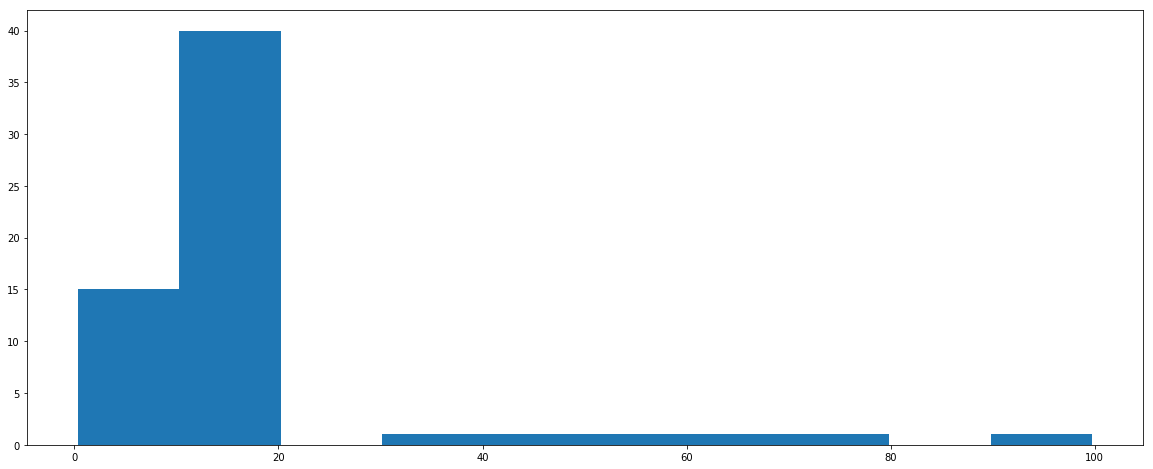

In [10]:
# Investigate patterns in the amount of missing data in each column.

plt.figure(figsize=(20, 8))
plt.hist(missing_values_percent)

<Container object of 61 artists>

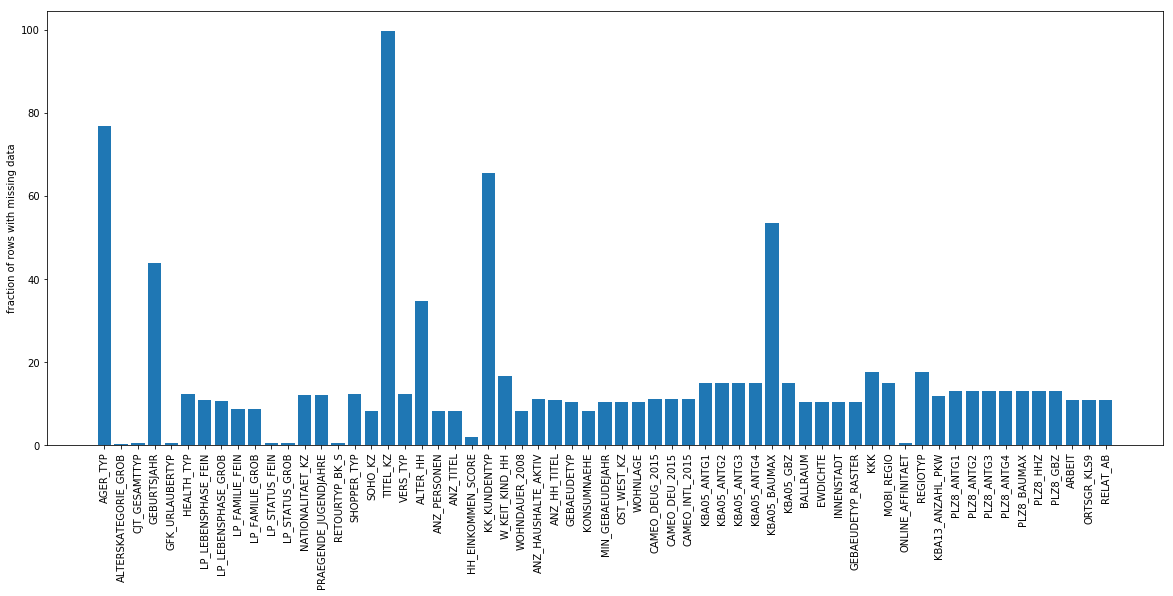

In [11]:
#bar graph to see 
plt.figure(figsize=(20,8))
plt.xticks(np.arange(len(missing_values_percent)),missing_values_percent.index,rotation='vertical')
plt.ylabel('fraction of rows with missing data')
plt.bar(np.arange(len(missing_values_percent)),missing_values_percent)

In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias = azdias.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], axis=1)

In [11]:
azdias.shape[1] #check

79

#### Discussion 1.1.2: Assess Missing Data in Each Column

We have 61 columns with at least one NaN value out of 85 columns.
Most columns have NaNs between 10-20% of the total and 79 out of 85 columns have NaNs between 0-20% only.
The top 6 columns with highest % of NaNs in the dataset are TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, and ALTER_HH with 99.8%, 77%, 65.6%, 53.5%, 44% and 34.8% of the rows as NaNs respectively. From going through the data dictionary, we get that
- **TITEL_KZ** = Title of the person
- **AGER_TYP** = Grouping amonst elderly people.
- **KK_KUNDENTYP** = Consumer type (house hold parameter)
- **KBA05_BAUMAX** = Most common building type within the microcell
- **GEBURTSJAHR** = Year of birth
- **ALTER_HH** = Birth date of head of household

Going through the above I've decided to remove all the above mentioned 6 outliers from the data.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [12]:
# How much data is missing in each row of the dataset?

#determine missing value counts & percentage
missing_values_rows = azdias.isnull().sum(axis=1)

(array([6.97109e+05, 7.76340e+04, 1.28010e+04, 9.53300e+03, 8.29000e+02,
        1.55000e+02, 1.40160e+04, 5.03100e+03, 2.80380e+04, 4.60750e+04]),
 array([ 0. ,  4.9,  9.8, 14.7, 19.6, 24.5, 29.4, 34.3, 39.2, 44.1, 49. ]),
 <a list of 10 Patch objects>)

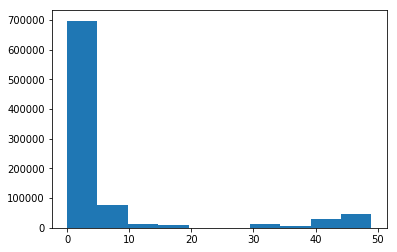

In [13]:
plt.hist(missing_values_rows)

As we have 0 rows between 20-30 NaNs, let's make 20 as the threshod for NaNs and process with the next step.

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

nan_threshold = 20 # missing values

rows_abv_threshold = missing_values_rows[missing_values_rows > nan_threshold]
rows_blw_threshold = missing_values_rows[missing_values_rows <= nan_threshold]

azdias_abv = azdias.iloc[rows_abv_threshold.index]
azdias_blw = azdias.iloc[rows_blw_threshold.index]

In [15]:
#check
azdias_abv.shape[0]

93795

In [16]:
#check
azdias_blw.shape[0]

797426

In [17]:
#check
azdias_blw.shape[1]

79

In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_tables(column):
    fig = plt.figure(figsize=(16,4))
    fig1 = fig.add_subplot(121)
    fig1.title.set_text('Above threshold: >20 fields missing')
    sns.countplot(azdias_abv[column])

    fig2 = fig.add_subplot(122)
    fig2.title.set_text('Below threshold: <=20 fields missing')
    sns.countplot(azdias_blw[column]);

    fig.suptitle(column)
    plt.show()

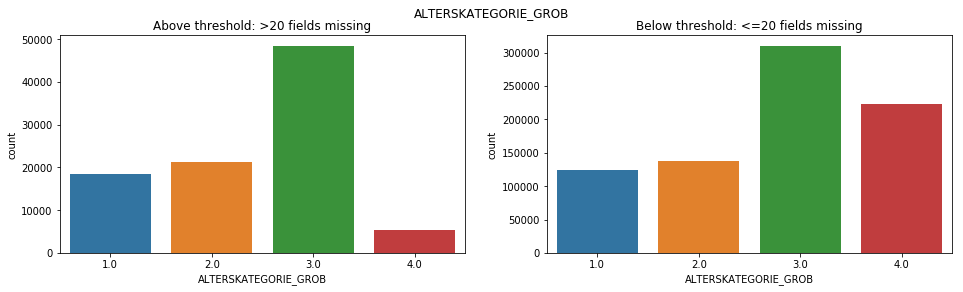

In [32]:
compare_tables('ALTERSKATEGORIE_GROB')

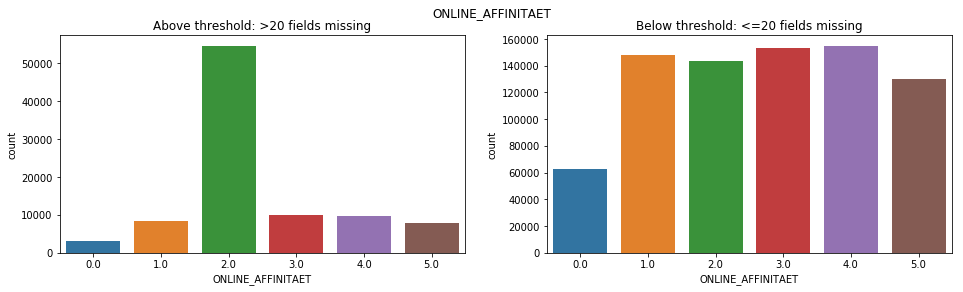

In [49]:
compare_tables('ONLINE_AFFINITAET')

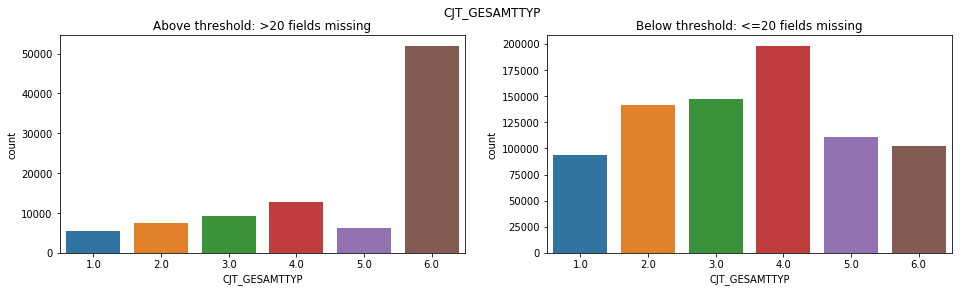

In [50]:
compare_tables('CJT_GESAMTTYP')

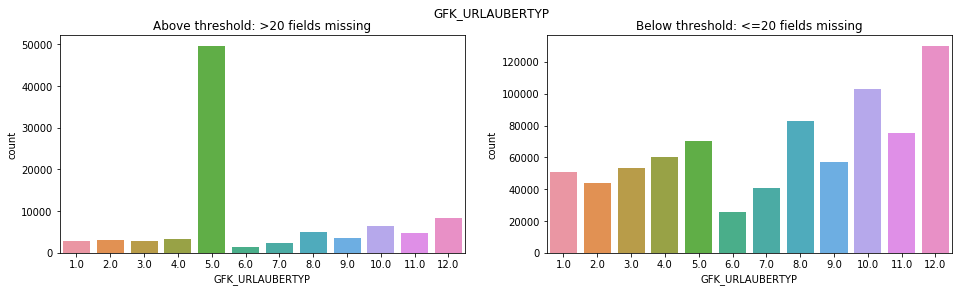

In [51]:
compare_tables('GFK_URLAUBERTYP')

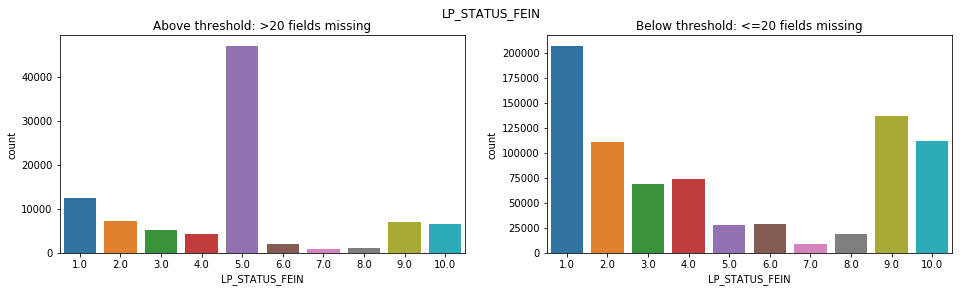

In [52]:
compare_tables('LP_STATUS_FEIN')

#### Discussion 1.1.3: Assess Missing Data in Each Row

I put a threshold of 20 maximum fields with NaNs for rows to classify them as rows with too many NaN columns. This gave me 10.5% of the overall dataset. When I compare the distributions on few columns with few missing values for both datasets (above and below thresholds), I see that for each of the column selected, the rows with too many NaNs have one unique value dominating the column while the below threshold is more even. Going in details for data with too many NaNs,
- **ALTERSKATEGORIE_GROB**:Estimated age was dominated by 46-60years old. 
- **ONLINE_AFFINITAET**: Online affinity was dominated by middle
- **CJT_GESAMTTYP**: Preferred buying channel dominated by Advertising-Enthusiast with restricted Cross-Channel-Behaviour
- **GFK_URLAUBERTYP**: Vacation habits dominated by Nature lovers
- **LP_STATUS_FEIN**: Social status dominated by minimalistic high-income earners

Since none of the distributions were similar, it makes sense to remove these rows instead of having them together, and hence the data in **azdias_abv** will not be used going forward for the analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?
feat_info['type'].groupby(feat_info['type']).count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and

def assess_categorical(df):
    encode_binary = []
    encode_multilevel = []
    for column in df.columns:
        if feat_info.iloc[feat_info.index[feat_info['attribute']==column][0],2] == 'categorical':
            if len(df[column].unique()) > 2:
                encode_multilevel.append(column)
            else:
                encode_binary.append(column)
    return encode_binary, encode_multilevel

encode_binary, encode_multilevel = assess_categorical(azdias_blw)

In [21]:
#check how many variables are in each bucket
print(len(encode_binary))
print(len(encode_multilevel))

4
14


In [22]:
# which one needs to be re-encoded?
for a in encode_binary:
    print(azdias_blw[a].value_counts())

2    415781
1    381645
Name: ANREDE_KZ, dtype: int64
0    622259
1    175167
Name: GREEN_AVANTGARDE, dtype: int64
0.0    790714
1.0      6712
Name: SOHO_KZ, dtype: int64
W    628987
O    168439
Name: OST_WEST_KZ, dtype: int64


**OST_WEST_KZ** binary variable needs to be encoded as it has non-numeric values

In [23]:
# Re-encode binary categorical variable(s) to be kept in the analysis.
azdias_blw['OST_WEST_KZ'].replace(['W','O'], [0,1], inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [24]:
#check
for a in encode_binary:
    print(azdias_blw[a].value_counts())

2    415781
1    381645
Name: ANREDE_KZ, dtype: int64
0    622259
1    175167
Name: GREEN_AVANTGARDE, dtype: int64
0.0    790714
1.0      6712
Name: SOHO_KZ, dtype: int64
0    628987
1    168439
Name: OST_WEST_KZ, dtype: int64


In [25]:
encode_multilevel

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [26]:
#re-encode multi level categorical features
azdias_blw = pd.get_dummies(azdias_blw, columns = encode_multilevel, drop_first=True)

In [27]:
#check
azdias_blw.shape[1]

181

#### Discussion 1.2.1: Re-Encode Categorical Features

- The overall columns increased from 79 to 181 after re-encoding the Categorical features. We have re-encoded one binary variable with non-numberic values and 14 multi-level categorical variables. We have used drop_first parameter in get_dummies to ensure we don't get the reference column in our data.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [28]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_blw['PRAEGENDE_JUGENDJAHRE'].head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [29]:
decade = {0:[1,2], 1:[3,4], 2:[5,6,7], 3:[8,9], 4:[10,11,12,13], 5:[14,15]}
movement = {0:[1,3,5,8,10,12,14], 1:[2,4,6,7,9,11,13,15]}

def map_decade(x):
    try:
        for key,value in decade.items():
            if x in value:
                return key
    except ValueError:
        return np.NaN

def map_movement(x):
    try:
        for key,value in movement.items():
            if x in value:
                return key
    except ValueError:
        return np.NaN

azdias_blw['decade']= azdias_blw['PRAEGENDE_JUGENDJAHRE'].apply(map_decade)
azdias_blw['movement']= azdias_blw['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)

In [30]:
#check
print(azdias_blw['decade'].value_counts())
print(azdias_blw['movement'].value_counts())

5.0    225424
3.0    175105
4.0    151701
2.0    114325
1.0     74272
0.0     28141
Name: decade, dtype: int64
0.0    593801
1.0    175167
Name: movement, dtype: int64


In [31]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_blw['CAMEO_INTL_2015'].head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

We see from Data Dictionary that **CAMEO_INTL_2015** has the first digit unique for Wealth and the 2nd digit unique for Lifetage

In [32]:
def map_wealth(x):
    try:
        return int(str(x)[0])
    except ValueError:
        return np.NaN
def map_lifestage(x):
    try:
        return int(str(x)[1])
    except ValueError:
        return np.NaN

azdias_blw['wealth']= azdias_blw['CAMEO_INTL_2015'].apply(map_wealth)
azdias_blw['lifestage']= azdias_blw['CAMEO_INTL_2015'].apply(map_lifestage)

In [33]:
#check
print(azdias_blw['wealth'].value_counts())
print(azdias_blw['lifestage'].value_counts())

5.0    223526
2.0    190508
4.0    189905
1.0    119362
3.0     68122
Name: wealth, dtype: int64
1.0    244961
4.0    232660
3.0    119559
5.0    116988
2.0     77255
Name: lifestage, dtype: int64


In [34]:
#get list of varaibles with mixed values
mixed_rows = feat_info.index[feat_info['type']== 'mixed'].tolist()

for i in mixed_rows:
    print(feat_info.iloc[i,0])

LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
PRAEGENDE_JUGENDJAHRE
WOHNLAGE
CAMEO_INTL_2015
KBA05_BAUMAX
PLZ8_BAUMAX


In [35]:
# Investigate "PLZ8_BAUMAX" and engineer two new variables.
def map_business_area(x):
    try:
        if x==5:
            return 1
        else:
            return 0
    except ValueError:
        return np.NaN

def map_family_homes(x):
    try:
        if x ==5:
            return 0
        else:
            return x
    except ValueError:
        return np.NaN

azdias_blw['business_area']= azdias_blw['PLZ8_BAUMAX'].apply(map_business_area)
azdias_blw['family_homes']= azdias_blw['PLZ8_BAUMAX'].apply(map_family_homes)

In [36]:
#check
print(azdias_blw['business_area'].value_counts())
print(azdias_blw['family_homes'].value_counts())

0    700093
1     97333
Name: business_area, dtype: int64
1.0    499542
0.0     97333
2.0     70406
4.0     56684
3.0     50732
Name: family_homes, dtype: int64


In [37]:
#check
azdias_blw.shape[1]

187

#### Discussion 1.2.2: Engineer Mixed-Type Features

Engineered **PRAEGENDE_JUGENDJAHRE**, **CAMEO_INTL_2015**, and **PLZ8_BAUMAX** columns. Leaving the other mixed variables as is. One of the mixed variables (**KBA05_BAUMAX**) has already been deleted due to too mnay missing values in the variable. Total columns increased to 187 (after adding 6 new columns).

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [38]:
#dropping the old columns from which we have engineered new columns
azdias_blw = azdias_blw.drop(columns = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX'])

In [39]:
#check
print(azdias_blw.shape[1],'\n',azdias_blw.shape[0])

184 
 797426


In [40]:
#check data types
np.unique(azdias_blw.dtypes.values)

array([dtype('uint8'), dtype('int64'), dtype('float64')], dtype=object)

In [92]:
#save work
azdias_blw.to_csv('azdias_cleaned.csv',sep=';', index=False)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [41]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter = ';')
    feat_info['missing_lists'] = feat_info['missing_or_unknown'].apply(lambda x: x.strip('[]').split(','))
    def int_or_str(x):
        try:
            return int(x)
        except ValueError:
            return x
    
    for i in range(len(feat_info['missing_lists'])):
        for j in range(len(feat_info['missing_lists'][i])):
            feat_info['missing_lists'][i][j]= int_or_str(feat_info['missing_lists'][i][j])
        
    for i in feat_info['attribute']:
        #for each value in missing/unknown list of values
        for each in feat_info['missing_lists'][feat_info.index[feat_info['attribute']==i][0]]:
            df[i]= df[i].replace(each,np.NaN)
    
    # remove selected columns and rows, ...
    df = df.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], axis=1)
    
    missing_values_rows = df.isnull().sum(axis=1)
    nan_threshold = 20 # missing values

    rows_abv_threshold = missing_values_rows[missing_values_rows > nan_threshold]
    rows_blw_threshold = missing_values_rows[missing_values_rows <= nan_threshold]

    df = df.iloc[rows_blw_threshold.index]
    
    # select & re-encode variables
    def assess_categorical(df):
        encode_binary = []
        encode_multilevel = []
        for column in df.columns:
            if feat_info.iloc[feat_info.index[feat_info['attribute']==column][0],2] == 'categorical':
                if len(df[column].unique()) > 2:
                    encode_multilevel.append(column)
                else:
                    encode_binary.append(column)
        return encode_binary, encode_multilevel

    encode_binary, encode_multilevel = assess_categorical(df)
    
    df['OST_WEST_KZ'].replace(['W','O'], [0,1], inplace = True)
    df = pd.get_dummies(df, columns = encode_multilevel,drop_first=True)
    
    #engineer variables
    decade = {0:[1,2], 1:[3,4], 2:[5,6,7], 3:[8,9], 4:[10,11,12,13], 5:[14,15]}
    movement = {0:[1,3,5,8,10,12,14], 1:[2,4,6,7,9,11,13,15]}

    def map_decade(x):
        try:
            for key,value in decade.items():
                if x in value:
                    return key
        except ValueError:
            return np.NaN
    def map_movement(x):
        try:
            for key,value in movement.items():
                if x in value:
                    return key
        except ValueError:
            return np.NaN

    df['decade']= df['PRAEGENDE_JUGENDJAHRE'].apply(map_decade)
    df['movement']= df['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)
    
    def map_wealth(x):
        try:
            return int(str(x)[0])
        except ValueError:
            return np.NaN
    def map_lifestage(x):
        try:
            return int(str(x)[1])
        except ValueError:
            return np.NaN
        
    df['wealth']= df['CAMEO_INTL_2015'].apply(map_wealth)
    df['lifestage']= df['CAMEO_INTL_2015'].apply(map_lifestage)
    
    def map_business_area(x):
        try:
            if x==5:
                return 1
            else:
                return 0
        except ValueError:
            return np.NaN
    def map_family_homes(x):
        try:
            if x ==5:
                return 0
            else:
                return x
        except ValueError:
            return np.NaN

    df['business_area']= df['PLZ8_BAUMAX'].apply(map_business_area)
    df['family_homes']= df['PLZ8_BAUMAX'].apply(map_family_homes)
    
    df = df.drop(columns = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX'])
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [42]:
azd = azdias_blw

In [55]:
azd = pd.read_csv('azdias_cleaned.csv',sep=';')

In [43]:
#save headers before we go to scaling
headers = azd.columns.tolist()
headers

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBE

In [44]:
#check
azd.shape[1]

184

In [47]:
azd.isna().sum()

ALTERSKATEGORIE_GROB      2784
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
HEALTH_TYP               36417
LP_LEBENSPHASE_FEIN      49651
LP_LEBENSPHASE_GROB      46830
RETOURTYP_BK_S            4634
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KAEM                   0
SEMIO_PFLICHT                0
SEMIO_TRADV                  0
SOHO_KZ                      0
ANZ_PERSONEN                 0
ANZ_TITEL                    0
                         ...  
CAMEO_DEU_2015_5C            0
CAMEO_DE

In [45]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer

imp = Imputer(strategy='most_frequent', axis=0)

azd = imp.fit_transform(azd)
azd = pd.DataFrame(azd)

In [46]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_azd = scaler.fit_transform(azd)

In [47]:
scaled_azd = pd.DataFrame(scaled_azd)

In [48]:
#check
print(np.std(scaled_azd, axis=0))
print(np.mean(scaled_azd, axis=0))

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
5      1.0
6      1.0
7      1.0
8      1.0
9      1.0
10     1.0
11     1.0
12     1.0
13     1.0
14     1.0
15     1.0
16     1.0
17     1.0
18     1.0
19     1.0
20     1.0
21     1.0
22     1.0
23     1.0
24     1.0
25     1.0
26     1.0
27     1.0
28     1.0
29     1.0
      ... 
154    1.0
155    1.0
156    1.0
157    1.0
158    1.0
159    1.0
160    1.0
161    1.0
162    1.0
163    1.0
164    1.0
165    1.0
166    1.0
167    1.0
168    1.0
169    1.0
170    1.0
171    1.0
172    1.0
173    1.0
174    1.0
175    1.0
176    1.0
177    1.0
178    1.0
179    1.0
180    1.0
181    1.0
182    1.0
183    1.0
Length: 184, dtype: float64
0     -6.650437e-15
1     -9.867674e-15
2     -5.939413e-15
3      1.416197e-15
4      2.436810e-14
5     -1.211866e-14
6      1.928393e-14
7      1.642516e-14
8     -9.846672e-16
9      1.455145e-16
10    -1.669180e-15
11     2.190750e-15
12    -2.208832e-15
13    -7.035957e-15
14     5.852922e-15
1

### Discussion 2.1: Apply Feature Scaling

- Applied feature scaling as needed. Ensured that I saved the headers for future reference. Checked if the mean and standard deviation is as expected (0, and 1 respecitively). 
- Thing to note is that, even though mean is supposed to be 0, it is not exactly 0, but close to it.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [49]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
reduced_azd = pca.fit_transform(scaled_azd)

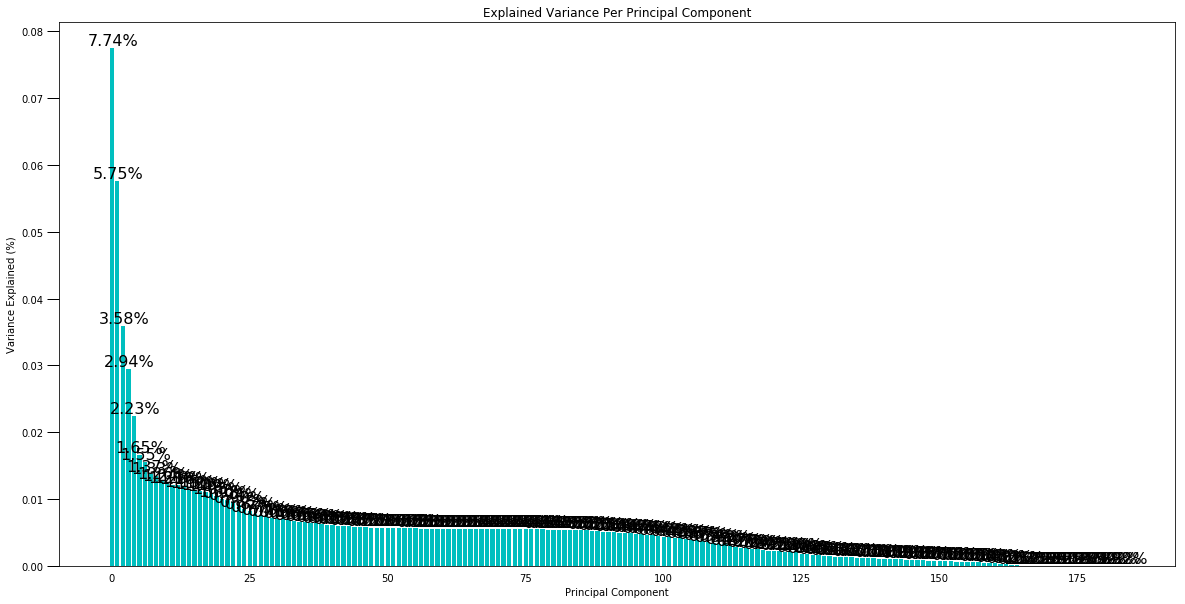

In [12]:
def scree_plot_individual(pca):
    '''
    Creates a scree plot showing individual components variance explained
    INPUT: pca - the result of instantian of PCA in scikit learn     
    OUTPUT: None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals, color='c')

    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=16)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=1, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
    
scree_plot_individual(pca)

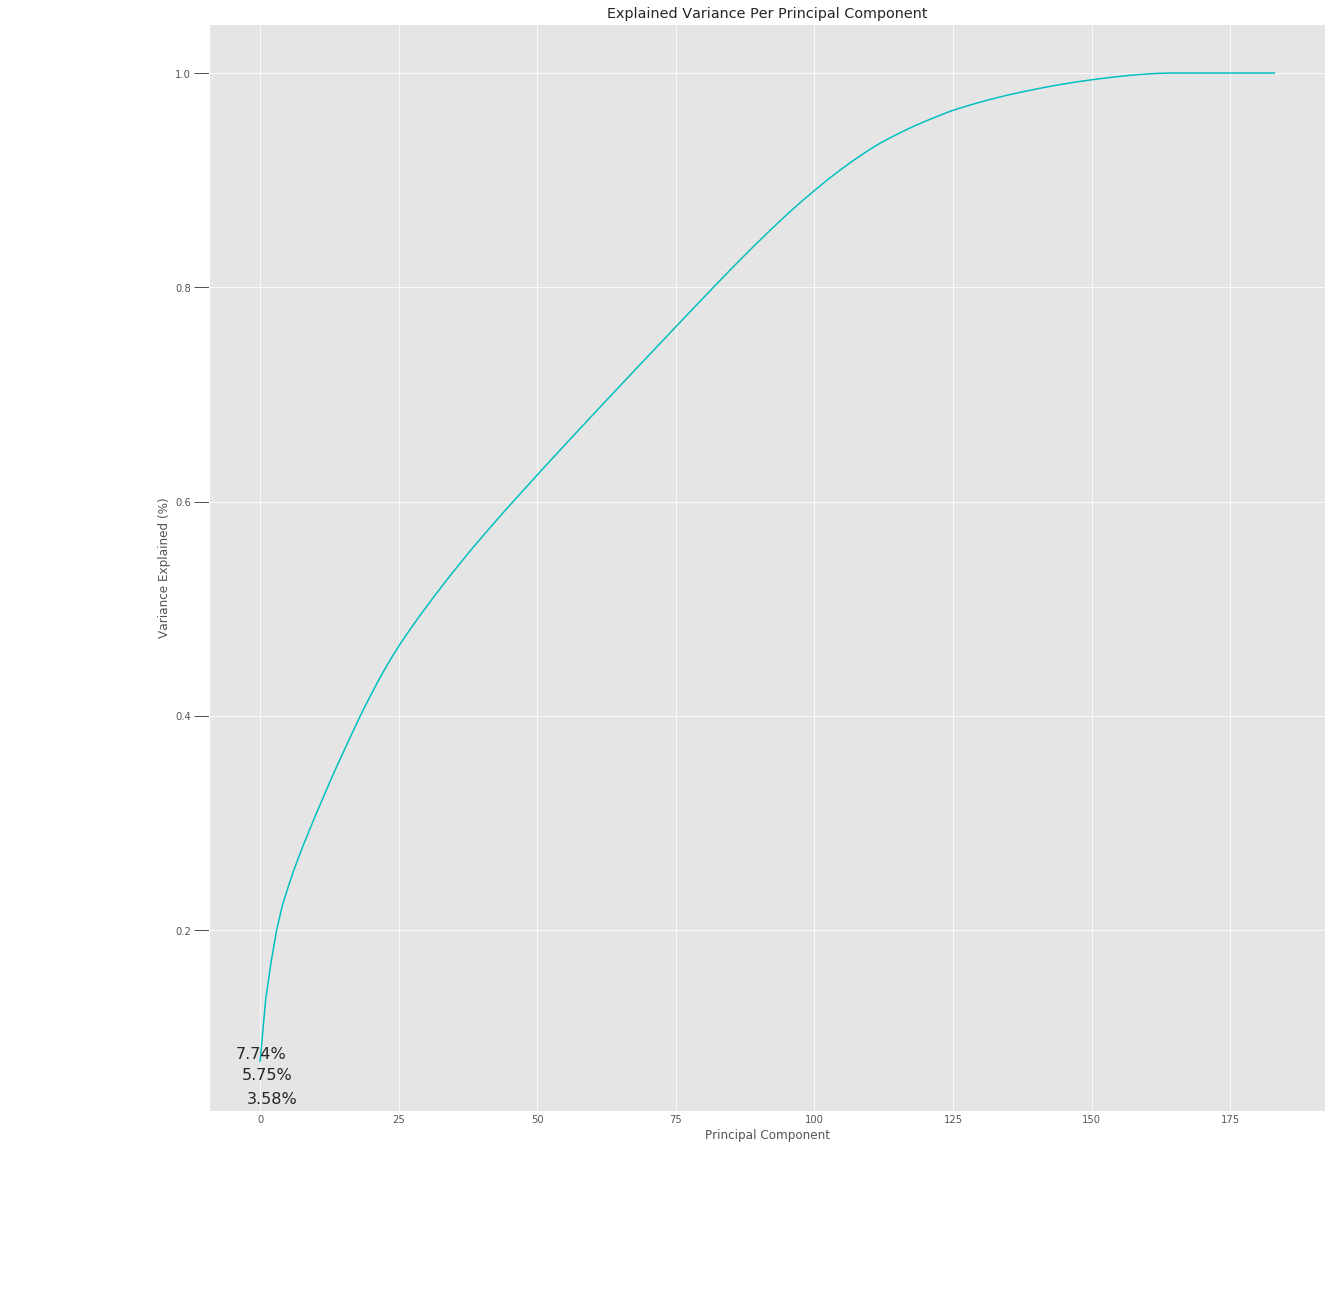

In [47]:
def scree_plot_cumulative(pca):
    '''
    Creates a scree plot showing individual components variance explained
    INPUT: pca - the result of instantian of PCA in scikit learn     
    OUTPUT: None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 20))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.plot(ind, cumvals, color ='c')
    
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=16)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=1, length=15)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
    
scree_plot_cumulative(pca)

In [50]:
#check pca cumulative values
pca_variance = pca.explained_variance_ratio_.tolist()
print(np.sum(pca_variance[:31]))

0.5018490673103725


In [51]:
# Re-apply PCA to the data while selecting for number of components to retain.
from sklearn.decomposition import PCA
pca = PCA(31)
reduced_azd = pca.fit_transform(scaled_azd)

### Discussion 2.2: Perform Dimensionality Reduction

- We see that there are two major shifts in the cumnulative graph. One around 31 features where we see cuulative variance explained is 50% and one around 104 features, where the cumulative variance explained is 90%. I have decided for this project that I'll proceed with 31 features.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [52]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.


# prints top 5 and bottom 5 weights and their feature names.
def component_weight(x, Count_of_weights):
    if int(x) in range(1,len(pca.components_)+1):
        weights = pd.DataFrame(pca.components_[x-1])
        weights.index = headers
        print('Weights of component {} are'.format(x))
        print(weights.sort_values(by=[0],ascending=False)[:Count_of_weights])
        print('-'*25)
        print(weights.sort_values(by=[0])[:Count_of_weights])
    else:
        print('please enter a number within the number of components available')
component_weight(1,5)

Weights of component 1 are
                           0
PLZ8_ANTG3          0.191025
wealth              0.189393
HH_EINKOMMEN_SCORE  0.186993
PLZ8_ANTG4          0.184167
ORTSGR_KLS9         0.163760
-------------------------
                          0
FINANZ_MINIMALIST -0.193944
MOBI_REGIO        -0.193192
PLZ8_ANTG1        -0.192152
KBA05_GBZ         -0.185582
KBA05_ANTG1       -0.185138


In [53]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component_weight(2,5)

Weights of component 2 are
                             0
ALTERSKATEGORIE_GROB  0.236807
FINANZ_VORSORGER      0.224501
ZABEOTYP_3            0.203687
SEMIO_ERL             0.185128
SEMIO_LUST            0.168053
-------------------------
                              0
decade                -0.234523
FINANZ_SPARER         -0.229163
SEMIO_REL             -0.219360
FINANZ_UNAUFFAELLIGER -0.216958
SEMIO_TRADV           -0.212465


In [30]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component_weight(3,5)

Weights of component 3 are
                    0
SEMIO_VERT   0.325435
SEMIO_SOZ    0.258940
SEMIO_FAM    0.258891
SEMIO_KULT   0.249194
FINANZTYP_5  0.143286
-------------------------
                   0
ANREDE_KZ  -0.348647
SEMIO_KAEM -0.315959
SEMIO_DOM  -0.282579
SEMIO_KRIT -0.267390
SEMIO_ERL  -0.204011


### Discussion 2.3: Interpret Principal Components

- **First Principal Component**: 
Explains 7.74% of the total variance. There are positive correlations between number of people in family, wealth of houshold, and home ownership (FINANZ_HAUSBAUER).
Above features are inversely related to Movement patterns, low financial interests, and low people family homes.

- **Second Principal Component**: 
Explains 5.75% of the total variance. There are positive correlations between age, being prepared financially, shopping behavious, sensual mindset and event oriented mindset.
Above features are inversely related to religious nature, money saver, decade of birth, and traditional mindset.

- **Third Principal Component**: 
Explains 3.58% of the total variance. There are positive correlations between social, dreamful, cultural oriented and family mindsets.
Above features are inversely related to the other mindsets available in the data.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [54]:
from sklearn.cluster import KMeans

# function to get kmeans score for given centers
def get_kmeans_score(df, cluster_count):
    kmeans = KMeans(n_clusters=cluster_count)
    model = kmeans.fit(df)
    score = np.abs(model.score(df))
    return score

In [ ]:
#create sample data from actual data to reduce computation time as KMeans is a slow algorithm
reduced_azd_sample = pd.DataFrame(reduced_azd[np.random.choice(reduced_azd.shape[0],int(reduced_azd.shape[0]*0.2), replace=False)])

In [62]:
# run k-means clustering on the sample data
k_values = list(range(2,30,3))
scores =[]
for k in k_values:
    scores.append(get_kmeans_score(reduced_azd_sample,k))

In [63]:
scores

[12892405.834369173,
 11016116.671835592,
 10258608.815502707,
 9733124.0232214797,
 9301198.6720799748,
 8999712.7463825028,
 8688697.6597823054,
 8474788.4534260668,
 8235385.7427076055,
 8037777.4367652396]

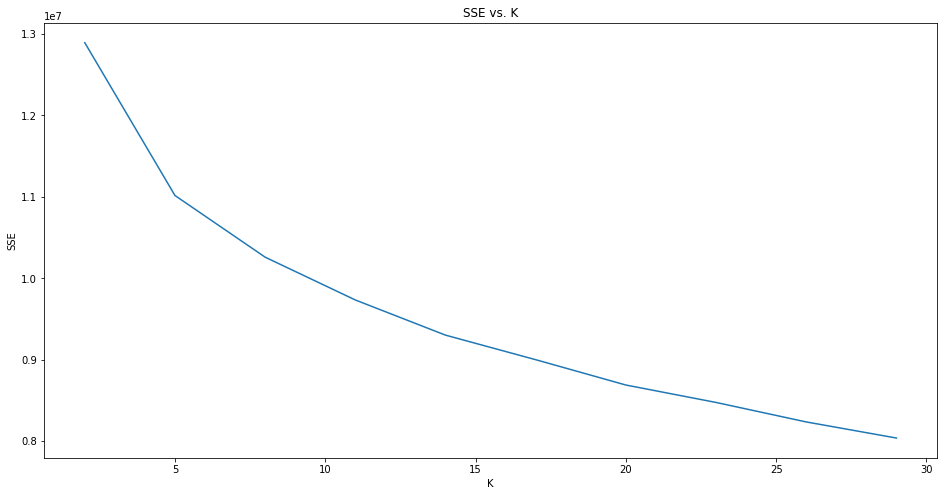

In [70]:
# Investigate the change in within-cluster distance (score) across number of clusters.
k_values = np.array(k_values)
scores = np.array(scores)

plt.figure(figsize=(16, 8))
plt.plot(k_values, scores)
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [66]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
selected_clusters = 5
kmeans = KMeans(selected_clusters)
model = kmeans.fit(reduced_azd)
pop_clusters = model.predict(reduced_azd)

### Discussion 3.1: Apply Clustering to General Population

- After mapping the scores (average-distances within the cluster to the centroid from the data points) for differnt K values, there is no obvious one choise which is standing out. Rather there is one clear slight descent indicator at k = 5. Further reasearch and online learnings did not give me any indicator on what should be the right k value for a data size which we have. I chose to select the k value **5** to proceed with my project.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [56]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter = ';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [57]:
customers['GEBAEUDETYP'].value_counts()

1.0    95145
3.0    23655
8.0    20475
2.0     2057
4.0      251
6.0      142
Name: GEBAEUDETYP, dtype: int64

In [12]:
customers.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,141176.000000,141176.000000,141176.000000
mean,0.344359,3.060907,1.376432,3.677928,3.963773,2.057051,4.183317,2.439808,2.646176,2.781176,...,2.537404,2.731510,1.388817,0.539939,1.556607,3.634893,3.622192,2.824850,5.119517,2.898510
std,1.391672,1.086254,0.484492,1.813975,1.036230,1.319422,0.995365,1.697932,1.586506,1.147353,...,0.904927,0.840922,0.885038,0.637048,1.185736,0.933660,1.008472,1.012415,2.159184,1.422683
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,-1.000000,3.000000,1.000000,2.000000,3.000000,1.000000,3.000000,1.000000,1.000000,2.000000,...,2.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,2.000000,4.000000,2.000000
50%,0.000000,3.000000,1.000000,4.000000,4.000000,1.000000,5.000000,2.000000,2.000000,3.000000,...,3.000000,3.000000,1.000000,0.000000,1.000000,3.000000,4.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,6.000000,5.000000,4.000000,5.000000,5.000000,5.000000,3.000000,...,3.000000,3.000000,2.000000,1.000000,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.000000


In [13]:
customers.shape[0]

191652

In [60]:
customers.shape[1]

85

In [59]:
#preprocessing the data
customers_cleaned = clean_data(customers)
customers_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,decade,movement,wealth,lifestage,business_area,family_homes
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,1.0,1.0,1.0,3.0,0,1.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,0,1.0,1.0,3.0,4.0,0,3.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0,0,0,0,0.0,0.0,2.0,4.0,0,1.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,0,3.0,0.0,4.0,1.0,0,2.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,0,0,1.0,1.0,3.0,4.0,0,1.0


In [61]:
#check for column count match in both customer and population after cleaning
def add_missing_dummy_columns(d, columns):
    missing_cols = set(columns) - set(d.columns)
    print(missing_cols)
    for c in missing_cols:
        d[c] = 0
           
def fix_columns(d, columns):  
    add_missing_dummy_columns(d, columns)
    # make sure we have all the columns we need
    assert(set(columns) - set(d.columns) == set())
    extra_cols = set(d.columns) - set(columns)
    if extra_cols:
        print("extra columns:", extra_cols)
    d = d[columns]
    return d
customers_cleaned = fix_columns(customers_cleaned, azdias_blw.columns.tolist())
customers_cleaned.head()

{'GEBAEUDETYP_5.0'}


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,decade,movement,wealth,lifestage,business_area,family_homes
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,1.0,1.0,1.0,3.0,0,1.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,0,1.0,1.0,3.0,4.0,0,3.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0,0,0,0,0.0,0.0,2.0,4.0,0,1.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,0,3.0,0.0,4.0,1.0,0,2.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,0,0,1.0,1.0,3.0,4.0,0,1.0


In [48]:
customer_headers = customers_cleaned.columns.tolist()
customer_headers

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBE

In [62]:
#replacing missed values
customers_cleaned = imp.transform(customers_cleaned)
customers_cleaned = pd.DataFrame(customers_cleaned)
customers_cleaned.head()

,0,1,2,3,4,5,6,7,8,9,...,174,175,176,177,178,179,180,181,182,183
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0
1,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,0.0,0.0,0.0,0.0,1.0,1.0,3.0,4.0,0.0,3.0
2,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,1.0
3,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,3.0,0.0,4.0,1.0,0.0,2.0
4,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,0.0,0.0,0.0,0.0,1.0,1.0,3.0,4.0,0.0,1.0


In [65]:
#feature scaling
customers_scaled = scaler.transform(customers_cleaned)
pd.DataFrame(customers_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,174,175,176,177,178,179,180,181,182,183
0,1.184051,-1.043765,1.409069,-1.155304,1.137960,-1.249881,-0.469752,-0.792034,1.884775,-1.633717,...,-0.189578,-0.179852,-0.192844,-0.089743,-1.633243,1.884775,-1.551476,0.094845,-0.372865,-0.305125
1,1.184051,0.958071,1.409069,-1.155304,1.137960,-1.249881,0.959677,0.628533,1.884775,-0.311674,...,-0.189578,-0.179852,-0.192844,-0.089743,-1.633243,1.884775,-0.187871,0.766845,-0.372865,1.684454
2,1.184051,-1.043765,1.409069,-1.155304,1.137960,-0.570799,-1.184467,-0.792034,-0.530567,-0.311674,...,-0.189578,-0.179852,-0.192844,-0.089743,-2.316187,-0.530567,-0.869674,0.766845,-0.372865,-0.305125
3,0.200589,-1.043765,-0.042770,-1.155304,0.411731,0.787366,1.674391,-0.792034,-0.530567,1.010368,...,-0.189578,-0.179852,-0.192844,-0.089743,-0.267356,-0.530567,0.493932,-1.249157,-0.372865,0.689664
4,0.200589,-1.043765,1.409069,-1.155304,1.137960,-1.249881,-0.469752,-0.081750,1.884775,1.010368,...,-0.189578,-0.179852,-0.192844,-0.089743,-1.633243,1.884775,-0.187871,0.766845,-0.372865,-0.305125


In [64]:
#pca
customers_reduced = pca.transform(customers_scaled)
pd.DataFrame(customers_reduced).head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,-3.037092,-0.436158,-2.705174,3.740630,-2.805562,0.714608,0.611713,-0.305848,0.027099,-0.780452,...,-1.033595,0.124272,-1.363962,-0.114801,-0.315533,-1.047049,-0.393962,0.190621,0.629703,-0.833915
1,2.588315,0.074991,-3.312114,2.770856,3.882328,-0.723040,-0.157738,-0.870804,0.624524,-1.170159,...,1.719368,-0.771639,0.135672,1.577275,-0.540099,-1.430044,0.586931,-0.107768,0.395300,2.256311
2,-0.293171,-3.684407,3.059643,3.932090,-4.478863,-0.123353,0.306383,1.403569,1.177498,0.332469,...,-3.194091,-0.207405,-3.504908,-2.603038,-0.684825,-0.181900,-0.147513,-1.971040,-1.214320,-1.485844
3,2.168246,-0.962090,2.068482,-5.082574,0.265428,-0.082767,0.004137,-0.384556,0.391044,1.104092,...,-0.887955,0.574767,-1.111571,1.426763,1.995720,-0.124550,-1.887734,0.733620,0.054598,0.583255
4,0.303284,8.806305,1.543833,1.266328,-2.004143,-3.033631,-3.582174,-3.601807,-1.189379,-3.509399,...,-1.754553,-0.827340,0.155874,-0.473495,-0.492531,0.008902,0.698198,0.270972,-0.109957,1.936459


In [67]:
#clustering using KMeans
customer_clusters = model.predict(customers_reduced)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [68]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

#customer cluster counts
customer_clusters = pd.Series(customer_clusters)
cc = customer_clusters.value_counts().sort_index()
cc = pd.Series(cc)
cc

0    38876
1    17204
2    29616
3    37017
4    18927
dtype: int64

In [69]:
#add removed customer data as another cluster
count = len(customers)-len(customers_reduced)
cc = pd.concat([pd.Series([count]),cc])
cc

0    50012
0    38876
1    17204
2    29616
3    37017
4    18927
dtype: int64

In [70]:
#population cluster counts
pop_clusters = pd.Series(pop_clusters)
pc = pop_clusters.value_counts().sort_index()
pc = pd.Series(pc)
pc

0    157758
1    118717
2    147830
3    159323
4    213798
dtype: int64

In [71]:
#add removed population rows count as another cluster
pc = pd.concat([pd.Series([len(azdias_abv)]),pc])
pc

0     93795
0    157758
1    118717
2    147830
3    159323
4    213798
dtype: int64

In [72]:
#create dataframe with population adn customer clusters
cluster_comparison = pd.concat([pc,cc],axis = 1).reindex()
cluster_comparison.columns=('population_count','customer_count')
cluster_comparison

,population_count,customer_count
0,93795,50012
0,157758,38876
1,118717,17204
2,147830,29616
3,159323,37017
4,213798,18927


In [73]:
#adding proportions & cluster details to table
cluster_comparison['population %']= (cluster_comparison['population_count']/\
                                     cluster_comparison['population_count'].sum()*100).round(2)
cluster_comparison['customer %']= (cluster_comparison['customer_count']/\
                                   cluster_comparison['customer_count'].sum()*100).round(2)
cluster_comparison['cluster']= list(range(-1,5))

cluster_comparison

,population_count,customer_count,population %,customer %,cluster
0,93795,50012,10.52,26.10,-1
0,157758,38876,17.70,20.28,0
1,118717,17204,13.32,8.98,1
2,147830,29616,16.59,15.45,2
3,159323,37017,17.88,19.31,3
4,213798,18927,23.99,9.88,4


Text(0.5,1,'Customer counts by cluster')

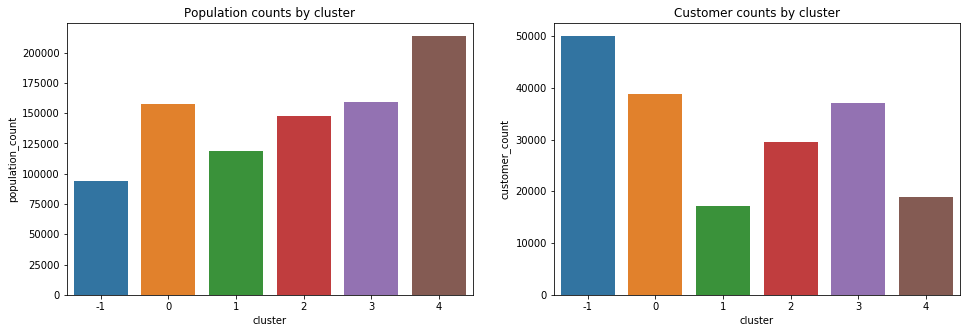

In [80]:
#population & Customer counts
ax = plt.figure(figsize=(16,5))
ax1 = ax.add_subplot(121)
ax1 = sns.barplot(x='cluster', y='population_count', data = cluster_comparison)
ax1.set_title('Population counts by cluster')

ax2 = ax.add_subplot(122)
ax2 = sns.barplot(x='cluster', y='customer_count', data = cluster_comparison)
ax2.set_title('Customer counts by cluster')


Text(0.5,1,'Customer % by Cluster')

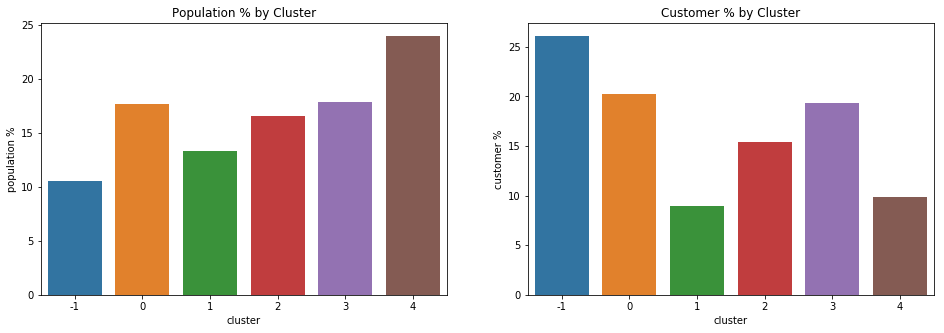

In [81]:
#population & Customer ratios
ax = plt.figure(figsize=(16,5))
ax1 = ax.add_subplot(121)
ax1 = sns.barplot(x='cluster', y='population %', data = cluster_comparison)
ax1.set_title('Population % by Cluster')

ax2 = ax.add_subplot(122)
ax2 = sns.barplot(x='cluster', y='customer %', data = cluster_comparison)
ax2.set_title('Customer % by Cluster')

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

**Cluster 0** seems to be overrepresented in Customer data when compared to general population data.

In [82]:
#See the component weights for Cluster 1
pd.Series(model.cluster_centers_[0]).sort_values(ascending=False)

1     0.886810
4     0.774873
5     0.407145
6     0.366623
23    0.296392
12    0.259307
10    0.174148
11    0.162473
21    0.144042
14    0.133503
17    0.030094
24    0.020754
19    0.016565
28    0.014108
8     0.002713
25    0.000076
7    -0.003672
15   -0.004591
30   -0.023237
29   -0.044301
26   -0.063199
27   -0.073908
16   -0.076761
22   -0.077740
13   -0.226289
20   -0.235849
18   -0.292415
9    -0.441554
2    -0.482402
3    -2.098620
0    -3.632721
dtype: float64

**We can see that Component 2 (Index value + 1) has the highest impact while Components 5,6,7,and 24 complete the top 5.**

In [83]:
#check underlying features behind the above components
component_weight(2,5)

Weights of component 2 are
                           0
LP_STATUS_FEIN_7.0  0.590984
ANZ_TITEL           0.441370
LP_STATUS_GROB_3.0  0.315291
FINANZTYP_5         0.166978
ANZ_HH_TITEL        0.153198
-------------------------
                           0
LP_STATUS_FEIN_9.0 -0.150610
LP_STATUS_GROB_4.0 -0.146018
WOHNLAGE           -0.114889
KKK                -0.109328
REGIOTYP           -0.089406


In [84]:
component_weight(5,5)

Weights of component 5 are
                   0
SEMIO_KAEM  0.308000
ANREDE_KZ   0.305991
SEMIO_ERL   0.249893
SEMIO_KRIT  0.245695
SEMIO_DOM   0.234456
-------------------------
                    0
SEMIO_KULT  -0.256924
SEMIO_VERT  -0.256299
SEMIO_FAM   -0.231278
FINANZTYP_5 -0.175713
SEMIO_MAT   -0.171487


In [85]:
component_weight(6,5)

Weights of component 6 are
                             0
LP_FAMILIE_GROB_5.0   0.276325
LP_LEBENSPHASE_GROB   0.199144
LP_FAMILIE_FEIN_11.0  0.196255
LP_FAMILIE_FEIN_10.0  0.183054
ALTERSKATEGORIE_GROB  0.178007
-------------------------
                            0
decade              -0.216265
SEMIO_RAT           -0.183187
LP_FAMILIE_GROB_4.0 -0.179781
HEALTH_TYP          -0.174235
SEMIO_PFLICHT       -0.153786


In [86]:
component_weight(7,5)

Weights of component 7 are
                            0
ANZ_HH_TITEL         0.533616
ANZ_TITEL            0.463919
CAMEO_DEU_2015_9E    0.207569
ANZ_HAUSHALTE_AKTIV  0.200501
LP_STATUS_GROB_5.0   0.104473
-------------------------
                           0
CAMEO_DEU_2015_1E  -0.472953
LP_STATUS_FEIN_7.0 -0.244010
LP_STATUS_GROB_3.0 -0.188793
LP_STATUS_FEIN_6.0 -0.076006
KBA05_ANTG2        -0.045631


In [87]:
component_weight(24,5)

Weights of component 24 are
                           0
PLZ8_HHZ            0.191734
LP_STATUS_FEIN_6.0  0.187835
FINANZTYP_5         0.177771
GEBAEUDETYP_4.0     0.171161
PLZ8_GBZ            0.169937
-------------------------
                             0
GEBAEUDETYP_2.0      -0.339306
FINANZTYP_2          -0.245064
LP_FAMILIE_FEIN_10.0 -0.192668
LP_FAMILIE_FEIN_2.0  -0.184215
LP_FAMILIE_GROB_2.0  -0.184215


Looking at the above weights, 
- Title holding households, & investor finance mindsets are more in the mail order custoemrs compared to overall population.
- We can see that the people with personalities who are combative, critical minded, event oriented and dominant play a big role for the mail order company.
- Multiperson & Multigenerational houselholds are also proportionally higher in the mail order company customers vs the overall population.

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

**Cluster 4** is significantly underrepresented in Customer dataa

In [173]:
#See the component weights for Cluster 4
pd.Series(model.cluster_centers_[4]).sort_values(ascending=False)

3     2.709206
0     0.330378
5     0.265024
14    0.106136
15    0.104506
29    0.089443
12    0.087294
19    0.061760
24    0.058839
25    0.052831
30    0.049995
11    0.040558
18    0.035848
22    0.031884
28    0.029472
13    0.026540
27    0.014150
26    0.000569
17   -0.032971
9    -0.069791
10   -0.083071
21   -0.106787
20   -0.111615
16   -0.130450
23   -0.133880
7    -0.147690
4    -0.181200
8    -0.206319
1    -0.210515
6    -0.323064
2    -2.844196
dtype: float64

Component 4 has the highest impact on Cluster 4 (almost 9 times more than the next Component 1).

In [175]:
#check underlying features behind Component 4
component_weight(4,5)

Weights of component 4 are
                            0
GREEN_AVANTGARDE     0.273189
movement             0.273189
LP_STATUS_GROB_5.0   0.232466
LP_STATUS_FEIN_10.0  0.232466
ORTSGR_KLS9          0.201947
-------------------------
                           0
WOHNLAGE           -0.202278
LP_STATUS_GROB_4.0 -0.172369
BALLRAUM           -0.162102
LP_STATUS_FEIN_9.0 -0.160973
INNENSTADT         -0.160682


Looking at the above weights,
- Membership in environmental sustainability as part of youth, movement (mainstream vs avantgarde) is significantly under represented in the mail order company customers.
- Top earners are not part of the mail order customers

### Discussion 3.3: Compare Customer Data to Demographics Data

Customer data of the mail order company had significantly low quality data with over 25% being lost due to missing values vs only 10% amongst the overall population data. THis may have lead to some inconsistencies int he output data. Nevertheless, we see 
- 3 clusters having similar representation: **Cluster 1, Cluster 2,** and **Cluster 3**
- **Cluster 0** was slightly over represented in Customer data vs the overall population data.
    > Customers here represent 
    - Title holding households, & investor finance mindsets are more in the mail order custoemrs compared to overall population.
    - We can see that the people with personalities who are combative, critical minded, event oriented and dominant play a big role for the mail order company.
    - Multiperson & Multigenerational houselholds are also proportionally higher in the mail order company customers vs the overall population.
- **Cluster 4** is significantly underrepresented in Customer data vs the overall population data.
    > Customer here include 
    - Membership in environmental sustainability as part of youth, movement (mainstream vs avantgarde)
    - Top earners